# 0. All Imports

In [53]:
# Basic
import os
import argparse
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data science
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import font_manager
from adjustText import adjust_text
import seaborn as sns

# Sklearn
from sklearn import linear_model
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Extra
from scipy.optimize import linear_sum_assignment
from mlxtend import frequent_patterns as fp

# 1. Load data

In [54]:
def load():

    ### Define the file paths
    file_path_1 = '_raw/Supplementary data 1.xlsx'
    file_path_2 = '_raw/Supplementary data 2.xlsx'

    ### Load data
    data = pd.read_excel(file_path_1)
    bm_meta_data = pd.read_excel(file_path_2)

    ### Save raw
    if not os.path.exists("data"):
        os.makedirs("data")
    data.to_csv("data/raw.csv", index=False)
    bm_meta_data.to_csv("data/meta.csv", index=False)

    ### Return df
    return data, bm_meta_data

# 2. Clean data

In [ ]:
def clean():

    data , bm_meta_data = load()

    ### Set the index of the data DataFrame to be the subject_ID
    data.set_index('SUBJECT_ID', inplace=True)

    ### Count missing values in the data DataFrame
    missing_values_per_feature = data.isnull().sum().to_dict()

    ### Drop features with more than 7% missing (according to article)
    features_to_drop = []
    threshold = 0.07 * data.shape[0]
    for feature, count in missing_values_per_feature.items():
        if count > threshold:
            features_to_drop.append(feature)
    data.drop(features_to_drop, axis=1, inplace=True)

    # Remove whitespace
    data.fillna('MISSING', inplace=True)
    data.replace(r'\s+', '', regex=True, inplace=True)  # Remove all whitespace characters (including tabs) from the data DataFrame
    data.replace('MISSING', pd.NA, inplace=True)        # Restore missing values to NaN

    # KKN imputation for missing values
    data_numeric = data.apply(pd.to_numeric, errors='coerce') # Convert all non-numeric data to numeric
    imputer = KNNImputer(n_neighbors=5) 
    data_imputed = pd.DataFrame(imputer.fit_transform(data_numeric), columns=data.columns, index=data.index)
    data = data_imputed

    ### Create new dataframes
    ### Find features in data that are not present in bm_meta_data
    non_bm_features = [col for col in data.columns if col not in bm_meta_data[bm_meta_data.columns[0]].values]
    data_bm = data.drop(non_bm_features, axis=1) # axis = 1 means we are dropping columns
    data_non_bm = data[non_bm_features]

    ### Create a dictionary from the biomarker_abbrev DataFrame
    bm_dict = dict(zip(bm_meta_data[bm_meta_data.columns[0]], bm_meta_data[bm_meta_data.columns[1]]))

    ### Save cleaned df
    data_bm.to_csv('data/cleaned.csv', index=False)
    data_non_bm.to_csv('data/non_bm.csv', index=False)

    ### Return dataframe
    return data_bm, bm_dict, data_non_bm

# 3. Preprocess data

In [57]:
def preprocess():

    # Read clean data
    df = pd.read_csv("data/cleaned.csv")

    # Logtransform specific columns
    cols_to_transform = ["ALP", "ALT", "AST", "CEA", "DBIL", "EO#", "EO%", "GGT", "HE4", "IBIL", "TBIL", "UA"]

    for col in cols_to_transform:
        # Ensure the column has no negative values before transforming
        min_value = df[df[col] > 0][col].min()

        if min_value < 0:
            raise ValueError(f"Column {col} contains negative values. Log transformation is not possible.")

        df[col] = np.log(df[col] + df[df[col] > 0][col].min() / 10)

    # Standardize all data
    df = (df - df.mean()) / df.std()

    # Save preprocessed df
    df.to_csv("data/preprocessed.csv", index=False)

    # Return preprocessed df
    return df

In [58]:
def new_split():
    # Load data sets
    df = pd.read_csv("data/preprocessed.csv")
    df_meta = pd.read_csv("data/non_bm.csv")

    # Gather data sets
    df_concat = pd.concat([df,df_meta],axis=1)

    df_meta1 = df_concat[["TYPE", "Age", "Menopause"]]

    # Split data sets into training and testing
    df2, df3 = train_test_split(df_concat, test_size=0.325, stratify=df_meta1["TYPE"], random_state=42)

    # Construct the meta data sets
    df_meta2 = df2[["TYPE", "Age", "Menopause"]]
    df_meta3 = df3[["TYPE", "Age", "Menopause"]]

    # Remove "TYPE", "Age", "Menopause" from the data sets
    df2 = df2.drop(columns=["TYPE", "Age", "Menopause"])
    df3 = df3.drop(columns=["TYPE", "Age", "Menopause"])

    # Save the data sets
    df_out = pd.concat([df2,df3],axis=0)
    df_meta_out = pd.concat([df_meta2,df_meta3],axis=0)

    df_out.to_csv("data/preprocessed_custom_split.csv", index=False)
    df_meta_out.to_csv("data/non_bm_custom_split.csv", index=False)

    return df_out, df_meta_out

# 4. PCA

### Utils

In [59]:
def plot_pca_cat_w_loadings(pcs_df, pca, features, color, save_path, split, top_n=8, scale_loading=5):
    # To get the variance explained on axis
    explained_variance_ratio = pca.explained_variance_ratio_

    # Get the PCA loadings (components) and calculate their vector lengths
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_) * scale_loading
    loading_lengths = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)

    # Take the number of most important loadings to display 
    top_indices = np.argsort(loading_lengths)[-top_n:]

    # Define the palette based on the 'color' argument
    if color == 'TYPE':
        palette = {'Cancer': 'red', 'Benign': 'lime'}
    elif color == 'Menopause':
        # Extract specific colors from Viridis colormap
        viridis = get_cmap('viridis')
        palette = {'Pre': 'orange', 'Post': "darkcyan"}  # Yellow at 0.1, Purple at 0.9

    plt.figure(figsize=(8, 6))

    # PC1 vs PC2 scatter plot
    sns.scatterplot(
        data=pcs_df, x='PC1', y='PC2', hue=color, 
        palette=palette,
        s=50
    )

    # Set axis titles with explained variance
    plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2%} variance)', fontsize=14)
    plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2%} variance)', fontsize=14)
    plt.suptitle(f'PCA of Dataset (PC1 vs PC2) with Top {top_n} Loadings', y=0.95, fontsize=16)
    plt.title(f'Using {split} split', fontsize=10)
    plt.legend(title = color, title_fontproperties=font_manager.FontProperties(weight='bold'))
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)

    # Add the most important loadings as arrows (vectors)
    texts = []
    for i in top_indices:
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='b', width=0.05, alpha=0.3, head_width=0.05, head_length=0.05)
        text = plt.text(loadings[i, 0], loadings[i, 1], features[i], color='darkblue', ha='center', va='center', fontweight='bold')
        texts.append(text)

    # Automatically adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Save the plot with the top loadings
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()


def plot_pca_cont_w_loadings(pcs_df, pca, features, color, save_path, split, top_n=8, scale_loading=5):
    # To get the variance explained on axis
    explained_variance_ratio = pca.explained_variance_ratio_

    # Get the PCA loadings (components) and calculate their vector lengths
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_) * scale_loading
    loading_lengths = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)

    # Take the number of most important loadings to display 
    top_indices = np.argsort(loading_lengths)[-top_n:]

    plt.figure(figsize=(8, 6))

    # PC1 vs PC2 scatter plot
    scatter = plt.scatter(pcs_df['PC1'], pcs_df['PC2'], c=pcs_df[color], cmap='plasma', s=50)

    # Add color bar to represent the scale of 'color'
    plt.colorbar(scatter, label=color)

    # Set axis titles with explained variance
    plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2%} variance)', fontsize=14)
    plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2%} variance)', fontsize=14)
    plt.suptitle(f'PCA of Dataset (PC1 vs PC2) with Top {top_n} Loadings', y=0.95, fontsize=16) # fiddle with y to ensure the two titles do not overlap
    plt.title(f'Using {split} split', fontsize=10)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)

    # Add the most important loadings as arrows (vectors)
    texts = []
    for i in top_indices:
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='b', alpha=0.5, width = 0.05, head_width=0.05, head_length=0.05)
        text = plt.text(loadings[i, 0], loadings[i, 1], features[i], color='darkblue', ha='center', va='center', fontweight='bold')
        texts.append(text)

    # Automatically adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Save the plot with the top loadings
    plt.grid(True)
    #plt.show()
    plt.savefig(save_path)
    plt.close()

### Main PCA calculations

In [60]:
def pca(split):
    # Path to save images, either predfined split or custom split
    if split == "predefined":
        path_to_save = 'results/pca_pre_split'
    elif split == "custom":
        path_to_save = 'results/pca_custom_split'
    else:
        print(f"'--split' must be either 'predefined' or 'custom', not {split}")
        sys.exit(1)
    os.makedirs(path_to_save, exist_ok=True)

    ### Load data
    if split == "predefined":
        df = pd.read_csv('data/preprocessed.csv')
        age_type_menopause = pd.read_csv('data/non_bm.csv')

    elif split == "custom":
        df = pd.read_csv('data/preprocessed_custom_split.csv')
        age_type_menopause = pd.read_csv('data/non_bm_custom_split.csv')


    # Replace 0 and 1 with 'Cancer' and 'Benign' in the 'TYPE' column
    age_type_menopause['TYPE'] = age_type_menopause['TYPE'].replace({0: 'Cancer', 1: 'Benign'})

    # Standardize age
    age_type_menopause['Age'] = (age_type_menopause['Age'] - age_type_menopause['Age'].mean()) / age_type_menopause['Age'].std()

    # Add age such that it is used in PCA
    df = pd.concat([df, age_type_menopause['Age']], axis=1)

    # Take only first 235 rows for training
    age_type_menopause = age_type_menopause.iloc[:235, :]
    df = df.iloc[:235, :]

    # Add menopause such that it is used in PCA
    df_scaled = pd.concat([df, age_type_menopause['Menopause']], axis=1)

    # Apply PCA
    pca = PCA()
    pcs_data = pca.fit_transform(df_scaled)

    # Convert the PCA results into a DataFrame
    pcs_df = pd.DataFrame(pcs_data, columns=[f'PC{i+1}' for i in range(pcs_data.shape[1])])

    # Add age_type_menopause to use the columns for colouring
    pcs_df = pd.concat([pcs_df, age_type_menopause], axis=1)
    pcs_df['Menopause'] = pcs_df['Menopause'].replace({0: 'Pre', 1: 'Post'})

    
    ### 1. Plot cumulative explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='b')
    plt.suptitle('Cumulative Explained Variance by Principal Components', y=0.95, fontsize=16) # fiddle with y to ensure the two titles do not overlap
    plt.title(f'Using {split} split', fontsize=10)
    plt.xlabel('Number of Principal Components', fontsize=14)
    plt.ylabel('Cumulative Explained Variance', fontsize=14)
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.show()
    plt.savefig(f"{path_to_save}/cumulative_explained_variance.png")
    plt.close()

    ### 2. Plot the loadings of the PCA as barplot
    features = df_scaled.columns

    # Create a DataFrame for easier plotting and sorting
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_lengths = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)
    loading_df = pd.DataFrame({
        'Feature': features,
        'Loading Magnitude': loading_lengths
    }).sort_values(by='Loading Magnitude', ascending=False)

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(loading_df['Feature'], loading_df['Loading Magnitude'], color='skyblue')
    plt.xlabel('Loading Magnitude')
    plt.ylabel('Features')
    plt.title(f'Using {split} split', fontsize=10)
    plt.suptitle('Feature Contributions to PC1 and PC2', y=0.95, fontsize=16) # fiddle with y to ensure the two titles do not overlap
    plt.gca().invert_yaxis()  # To have the largest loading at the top
    plt.show()
    plt.savefig(f"{path_to_save}/pca_loadings_magnitude.png")
    plt.close()

    # From the loadings magnitude plot, we see a drop after the first 8 features. Thus, we will only plot the top 8 loadings.
    print("The top 8 features are:")
    print(loading_df['Feature'][:8].tolist())

    ### 3. Plot PC1 vs PC2, colored by TYPE
    plot_pca_cat_w_loadings(pcs_df = pcs_df,
                            pca = pca,
                            features = df_scaled.columns,
                            color = 'TYPE',
                            save_path = f"{path_to_save}/pc1_vs_pc2_type.png",
                            split = split,
                            top_n=8)

    ### 4. Plot PC1 vs PC2, colored by Menopause
    plot_pca_cat_w_loadings(pcs_df = pcs_df,
                            pca = pca,
                            features = df_scaled.columns,
                            color = 'Menopause',
                            save_path = f"{path_to_save}/pc1_vs_pc2_menopause.png",
                            split = split,
                            top_n=8)

    ### 5. Plot PC1 vs PC2, colored by Age
    plot_pca_cont_w_loadings(pcs_df = pcs_df,
                            pca = pca,
                            features = df_scaled.columns,
                            color = 'Age',
                            save_path = f"{path_to_save}/pc1_vs_pc2_age.png",
                            split = split,
                            top_n=8)

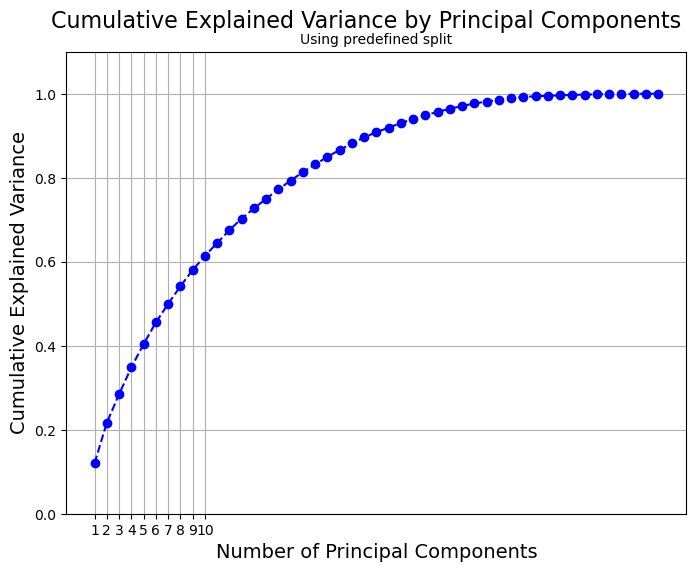

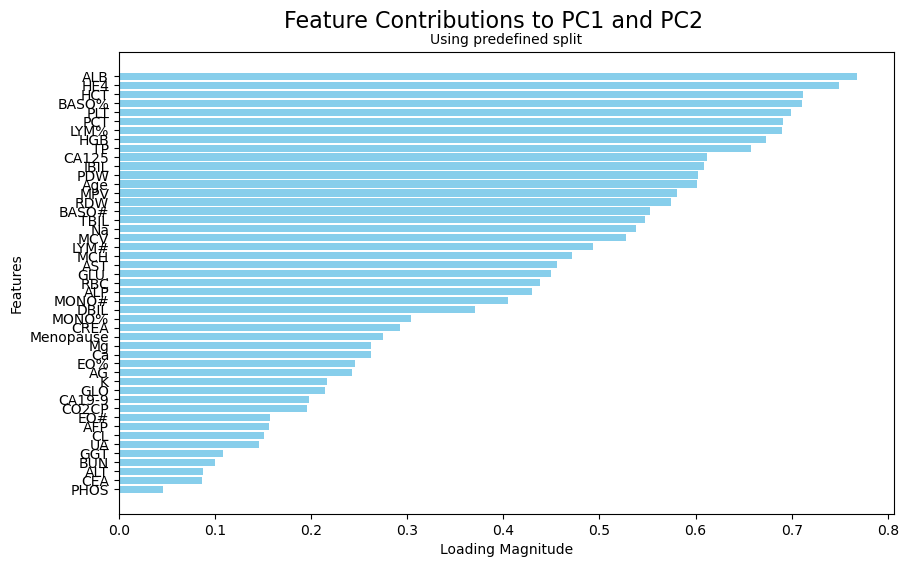

The top 8 features are:
['ALB', 'HE4', 'HCT', 'BASO%', 'PLT', 'PCT', 'LYM%', 'HGB']


In [61]:
pca(split="predefined")

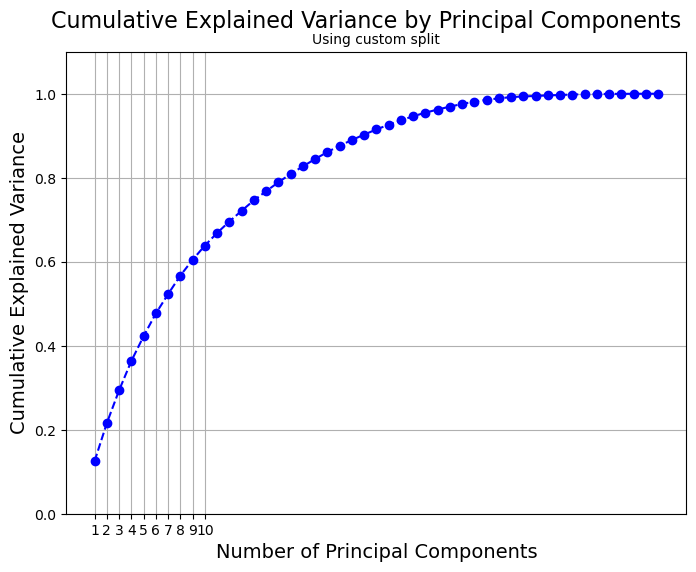

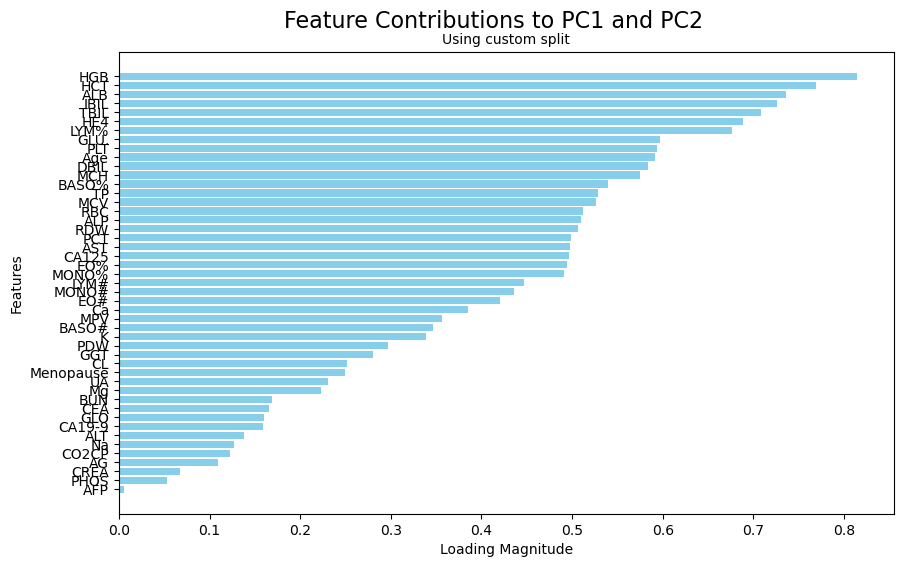

The top 8 features are:
['HGB', 'HCT', 'ALB', 'IBIL', 'TBIL', 'HE4', 'LYM%', 'GLU.']


In [62]:
pca(split="custom")

# 5. Apriori

In [63]:
def apriori(split):
    
    ### Load data
    if split == "predefined":
        df_clean = pd.read_csv('data/preprocessed.csv')
        df_meta = pd.read_csv('data/non_bm.csv')[['TYPE']].astype(bool)

    elif split == "custom":
        df_clean = pd.read_csv('data/preprocessed_custom_split.csv')
        df_meta = pd.read_csv('data/non_bm_custom_split.csv')[['TYPE']].astype(bool)
        
    df_clean = df_clean.iloc[:235]
    df_clean = df_clean.apply(lambda x: np.where(x > np.percentile(x, 50), 1, 0)).astype(bool) # median transformation
    df_meta['TYPE'] = ~df_meta['TYPE'] # To ensure that cancer (0) is the active item
    df_meta  = df_meta.iloc[:235]
    
    # concatenate dataframes
    df = pd.concat([df_clean, df_meta], axis=1).astype(bool)

    # Apply apriori algorithm (get itemsets)
    df_fp = fp.apriori(df, min_support=0.0001, use_colnames=True,max_len=4)

    # Find association rules (compute association metrics, given itemsets)
    df_conf = fp.association_rules(df_fp, metric='confidence', min_threshold=0.001)

    # only show consequents and antecedents that contain 'TYPE'
    top_rules = df_conf[df_conf['consequents'].apply(lambda x: 'TYPE' in x)].sort_values('lift', ascending=False)
    top_rules = top_rules[top_rules['confidence']<1][:25]

    display(top_rules)
    
    # Add nodes and edges
    all_nodes = []
    for _, row in top_rules.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                if consequent == 'TYPE':
                    all_nodes.append(antecedent)
        

    all_nodes = pd.Series(all_nodes)
    display(all_nodes.value_counts())

In [64]:
apriori(split="predefined")

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2046812,"(HE4, EO%)","(EO#, TYPE)",0.217021,0.246809,0.174468,0.803922,3.257268,0.120905,3.841277,0.885074
1104825,"(BASO%, HE4)","(BASO#, TYPE)",0.195745,0.195745,0.123404,0.630435,3.220699,0.085088,2.176220,0.857325
1104823,"(BASO#, HE4)","(BASO%, TYPE)",0.153191,0.251064,0.123404,0.805556,3.208569,0.084943,3.851672,0.812857
2046815,"(EO#, HE4)","(EO%, TYPE)",0.208511,0.268085,0.174468,0.836735,3.121153,0.118569,4.482979,0.858641
1099726,"(CA125, BASO%)","(BASO#, TYPE)",0.182979,0.195745,0.110638,0.604651,3.088979,0.074821,2.034293,0.827724
2259235,"(TBIL, HE4)","(IBIL, TYPE)",0.182979,0.259574,0.144681,0.790698,3.046130,0.097184,3.537589,0.822151
2259237,"(IBIL, HE4)","(TBIL, TYPE)",0.178723,0.268085,0.144681,0.809524,3.019652,0.096768,3.842553,0.814386
1593856,"(CA125, EO%)","(EO#, TYPE)",0.200000,0.246809,0.144681,0.723404,2.931034,0.095319,2.723077,0.823529
1099727,"(CA125, BASO#)","(BASO%, TYPE)",0.157447,0.251064,0.110638,0.702703,2.798901,0.071109,2.519149,0.762821
2023533,"(TBIL, HE4)","(DBIL, TYPE)",0.182979,0.285106,0.144681,0.790698,2.773343,0.092512,3.415603,0.782629


HE4      12
CA125     6
BASO%     4
TBIL      4
AST       4
BASO#     3
EO#       3
IBIL      3
EO%       2
DBIL      2
AFP       2
HGB       2
MCH       1
MCV       1
PLT       1
dtype: int64

In [65]:
apriori(split="custom")

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2259277,"(TBIL, HE4)","(IBIL, TYPE)",0.217021,0.182979,0.131915,0.607843,3.321933,0.092205,2.083404,0.892707
2259279,"(IBIL, HE4)","(TBIL, TYPE)",0.191489,0.208511,0.131915,0.688889,3.303855,0.091987,2.544073,0.862479
1104853,"(BASO%, HE4)","(BASO#, TYPE)",0.200000,0.225532,0.144681,0.723404,3.207547,0.099574,2.800000,0.860294
2046871,"(EO#, HE4)","(EO%, TYPE)",0.251064,0.208511,0.165957,0.661017,3.170183,0.113608,2.334894,0.914044
2046868,"(HE4, EO%)","(EO#, TYPE)",0.225532,0.234043,0.165957,0.735849,3.144082,0.113173,2.899696,0.880530
2023587,"(DBIL, HE4)","(TBIL, TYPE)",0.195745,0.208511,0.127660,0.652174,3.127773,0.086845,2.275532,0.845855
1104851,"(BASO#, HE4)","(BASO%, TYPE)",0.229787,0.208511,0.144681,0.629630,3.019652,0.096768,2.137021,0.868378
2265971,"(MCV, HE4)","(MCH, TYPE)",0.217021,0.165957,0.106383,0.490196,2.953746,0.070367,1.636007,0.844783
2023589,"(TBIL, HE4)","(DBIL, TYPE)",0.217021,0.200000,0.127660,0.588235,2.941176,0.084255,1.942857,0.842935
1628660,"(CA125, TBIL)","(IBIL, TYPE)",0.217021,0.182979,0.114894,0.529412,2.893297,0.075183,1.736170,0.835749


HE4      17
TBIL      5
CA125     4
BASO%     3
DBIL      3
IBIL      3
GLO       2
PCT       2
PLT       2
EO#       1
EO%       1
BASO#     1
MCV       1
MCH       1
HCT       1
HGB       1
RBC       1
TP        1
dtype: int64

# 6. Data split testing

In [66]:
def datasplit_test():
    # Load data
    df_bm = pd.read_csv('data/preprocessed.csv')[['HE4','CEA']]
    df_meta = pd.read_csv('data/non_bm.csv')[['TYPE']]

    df_bm_custom = pd.read_csv('data/preprocessed_custom_split.csv')[['HE4','CEA']]
    df_meta_custom = pd.read_csv('data/non_bm_custom_split.csv')[['TYPE']]

    # Split data
    train_df = df_bm.iloc[:235, :]
    train_labels_df = df_meta.iloc[:235]
    test_df = df_bm.iloc[235:, :]
    test_labels_df = df_meta.iloc[235:]

    train_df_custom = df_bm_custom.iloc[:235, :]
    train_labels_df_custom = df_meta_custom.iloc[:235]
    test_df_custom = df_bm_custom.iloc[235:, :]
    test_labels_df_custom = df_meta_custom.iloc[235:]

    # Define colors for TYPE. Color is created for All, Train, Test, Train_custom, Test_custom (as the order and length of TYPE is different)
    colors_all = df_meta
    colors_all = colors_all.replace(1, 0.4)
    colors_all = colors_all.replace(0, 1)

    colors_train = train_labels_df
    colors_train = colors_train.replace(1, 0.4)
    colors_train = colors_train.replace(0, 1)

    colors_test = test_labels_df
    colors_test = colors_test.replace(1, 0.4)
    colors_test = colors_test.replace(0, 1)

    colors_train_custom = train_labels_df_custom
    colors_train_custom = colors_train_custom.replace(1, 0.4)
    colors_train_custom = colors_train_custom.replace(0, 1)

    colors_test_custom = test_labels_df_custom
    colors_test_custom = colors_test_custom.replace(1, 0.4)
    colors_test_custom = colors_test_custom.replace(0, 1)

    # Plot
    fig, axs = plt.subplots(2,3, figsize=(18, 10), gridspec_kw={'hspace': 0.2})
    axs = axs.flatten()
    for ax in axs:
        ax.set_xlim(-1.8, 4)
        ax.set_ylim(-2.4, 5.25)

    custom_palette = {0: 'red', 1: 'lime'}    
    sns.scatterplot(x='HE4', y='CEA', hue='TYPE', palette=custom_palette, ax=axs[0], alpha=colors_all, data=pd.concat([df_bm, df_meta], axis=1), legend=False)
    sns.scatterplot(x='HE4', y='CEA', hue='TYPE', palette=custom_palette, ax=axs[1], alpha=colors_train, data=pd.concat([train_df, train_labels_df], axis=1), legend=False)
    sns.scatterplot(x='HE4', y='CEA', hue='TYPE', palette=custom_palette, ax=axs[2], alpha=colors_test, data=pd.concat([test_df, test_labels_df], axis=1), legend=False)
    sns.scatterplot(x='HE4', y='CEA', hue='TYPE', palette=custom_palette, ax=axs[4], alpha=colors_train_custom, data=pd.concat([train_df_custom, train_labels_df_custom], axis=1), legend=False)
    sns.scatterplot(x='HE4', y='CEA', hue='TYPE', palette=custom_palette, ax=axs[5], alpha=colors_test_custom, data=pd.concat([test_df_custom, test_labels_df_custom], axis=1), legend=False)

    # Remove axes for the empty subplot
    axs[3].axis('off')

    # Set titles for each subplot
    axs[0].set_title('All')
    axs[1].set_title('Train, predefined split')
    axs[2].set_title('Test, predefined split')
    axs[4].set_title('Train, custom split')
    axs[5].set_title('Test, custom split')

    # Remove x-axis labels for consistency
    axs[1].set_xlabel('')
    axs[2].set_xlabel('')

    # Remove y-axis labels for consistency
    axs[1].set_ylabel('')
    axs[2].set_ylabel('')
    axs[5].set_ylabel('')

    # Custom legends
    legend_labels = ['0', '1']  # Replace with your custom labels
    legend_colors = ['red', 'lime']  # Replace with your custom colors

    cn1 = df_meta['TYPE'].value_counts()
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip([f'Cancer (n={cn1[0]})',f'Benign (n={cn1[1]})'], legend_colors)]
    axs[0].legend(handles=custom_legend, title='TYPE')

    cn2 = train_labels_df['TYPE'].value_counts()
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip([f'Cancer (n={cn2[0]})',f'Benign (n={cn2[1]})'], legend_colors)]
    axs[1].legend(handles=custom_legend, title='TYPE')

    cn3 = test_labels_df['TYPE'].value_counts()
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip([f'Cancer (n={cn3[0]})',f'Benign (n={cn3[1]})'], legend_colors)]
    axs[2].legend(handles=custom_legend, title='TYPE')

    cn4 = train_labels_df_custom['TYPE'].value_counts()
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip([f'Cancer (n={cn4[0]})',f'Benign (n={cn4[1]})'], legend_colors)]
    axs[4].legend(handles=custom_legend, title='TYPE')

    cn5 = test_labels_df_custom['TYPE'].value_counts()
    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip([f'Cancer (n={cn5[0]})',f'Benign (n={cn5[1]})'], legend_colors)]
    axs[5].legend(handles=custom_legend, title='TYPE')

    plt.show()
    plt.savefig('results/red_handed.png')

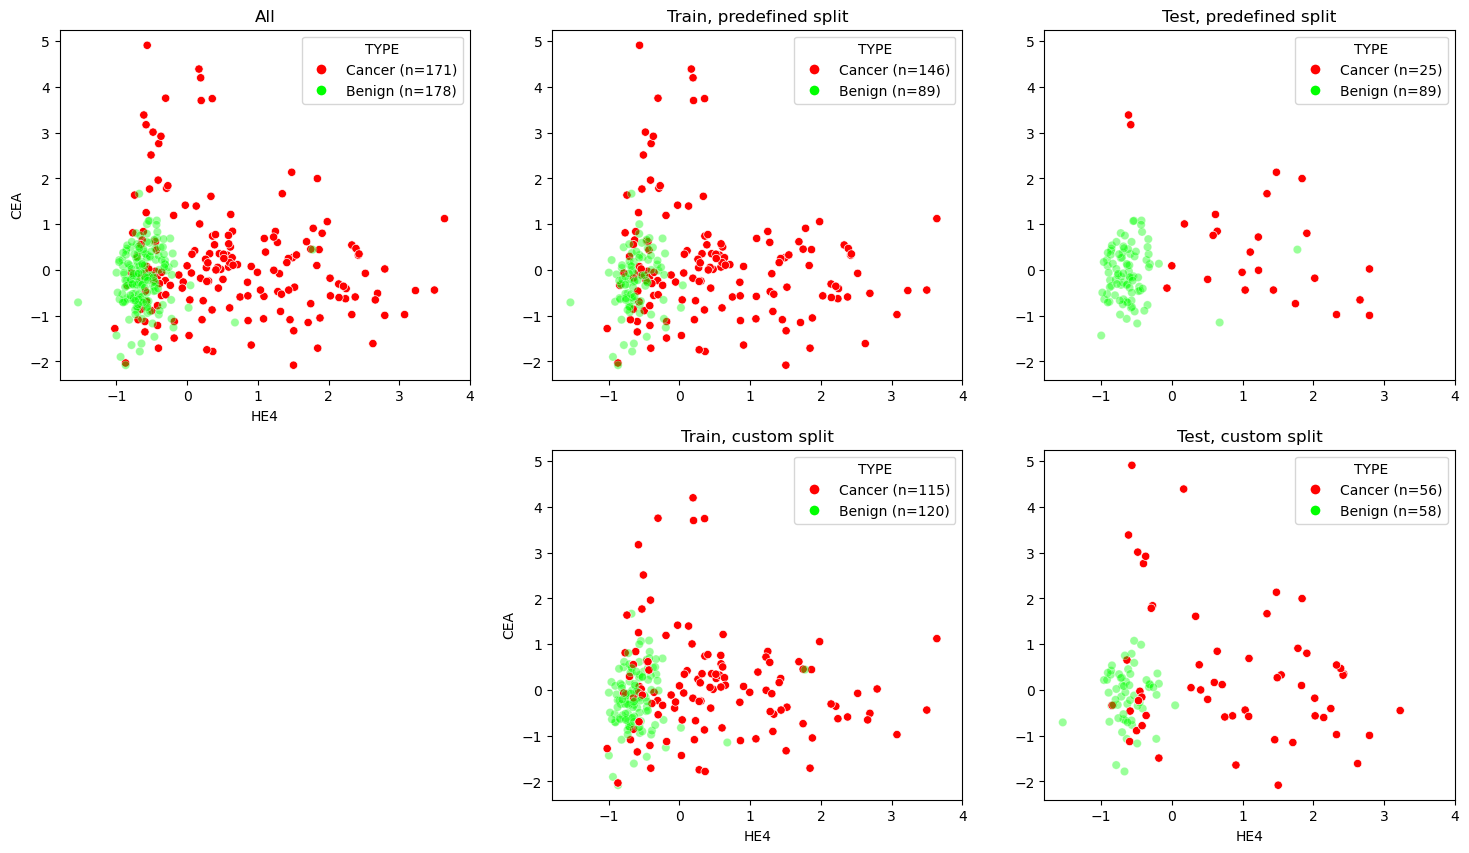

<Figure size 640x480 with 0 Axes>

In [67]:
datasplit_test()

# 7. Evaluation / Results

In [68]:
def model_eval(split):
    # Path to save images, either predfined split or custom split
    if split == "predefined":
        path_to_save = 'results/models_pre_split'
    elif split == "custom":
        path_to_save = 'results/models_custom_split'
    else:
        print(f"'--split' must be either 'predefined' or 'custom', not {split}")
        sys.exit(1)
    os.makedirs(path_to_save, exist_ok=True)

    ### Load data
    if split == "predefined":
        data = pd.read_csv('data/preprocessed.csv')
        age_type_menopause = pd.read_csv('data/non_bm.csv')
    elif split == "custom":
        data = pd.read_csv('data/preprocessed_custom_split.csv')
        age_type_menopause = pd.read_csv('data/non_bm_custom_split.csv')
    data = pd.concat([data, age_type_menopause[["Age", "Menopause"]]], axis=1)

    # Get first 235 rows for training
    train_df = data.iloc[:235, :]
    train_labels_df = age_type_menopause["TYPE"].iloc[:235]

    # Get last rows for testing
    test_df = data.iloc[235:, :]
    test_labels_df = age_type_menopause["TYPE"].iloc[235:]

    # Specify the subsets of columns you want to use
    subsets = [
        data.columns.tolist(),                                                # All features                       
        ['HE4', 'CA125', 'BASO%', 'TBIL', 'AST'],                             # Apriori Predefined Subset
        ['HE4', 'CA125', 'BASO%', 'TBIL', 'AST', 'CEA'],                      # Apriori Predefined Subset + CEA
        ['HE4', 'TBIL', 'CA125', 'BASO%', 'DBIL','IBIL'],                     # Apriori Custom Subset
        ['HE4', 'TBIL', 'CA125', 'BASO%', 'DBIL','IBIL', 'CEA'],              # Apriori Custom Subset + CEA
        ['ALB', 'HE4', 'HCT', 'BASO%', 'PLT', 'PCT', 'LYM%', 'HGB'],          # PCA Predefined Subset
        ['ALB', 'HE4', 'HCT', 'BASO%', 'PLT', 'PCT', 'LYM%', 'HGB', 'CEA'],   # PCA Predefined Subset + CEA
        ['HGB', 'HCT', 'ALB', 'IBIL', 'TBIL', 'HE4', 'LYM%', 'GLU.'],         # PCA Custom Subset
        ['HGB', 'HCT', 'ALB', 'IBIL', 'TBIL', 'HE4', 'LYM%', 'GLU.', 'CEA'],  # PCA Custom Subset + CEA
        ["Menopause", "Age", "AFP", "CEA", "HE4", "CA19-9", "LYM%", "CO2CP"], # Article, 8 subset
        ["HE4", "CEA"]                                                        # Article, 2 subset
        # Add more subsets as needed
    ]

    subset_names = [
        "All Features",
        "Apriori Predefined Subset",
        "Apriori Predefined Subset + CEA",
        "Apriori Custom Subset",
        "Apriori Custom Subset + CEA",
        "PCA Predefined Subset",
        "PCA Predefined Subset + CEA",
        "PCA Custopm Subset",
        "PCA Custom Subset + CEA",
        "Article, subset of 8",
        "Article, subset of 2"
        # Add more subset names as needed
    ]

    subset_file_names = [
        "all_features",
        "apriori_pre",
        "apriori_pre_cea",
        "apriori_custom",
        "apriori_custom_cea",
        "pca_pre",
        "pca_pre_cea",
        "pca_custom",
        "pca_custom_cea",
        "subset_eight",
        "subset_two"
        # Add more subset names as needed
    ]

    # Get true labels as Series and encode them
    train_labels = train_labels_df
    test_labels = test_labels_df
    n_classes = train_labels.nunique()

    # Encode labels as integers (not necessary in binary, but helpful for consistency)
    train_labels_encoded = (train_labels == 1).astype(int)
    test_labels_encoded = (test_labels == 1).astype(int)

    # Function to align cluster labels to true labels using the Hungarian algorithm
    def align_labels(true_labels, predicted_labels):
        cm = confusion_matrix(true_labels, predicted_labels)
        _, col_ind = linear_sum_assignment(-cm)
        aligned_labels = np.zeros_like(predicted_labels)
        for k in range(2): 
            aligned_labels[predicted_labels == col_ind[k]] = k
        return aligned_labels

    for i, subset in enumerate(subsets):
        # Select subset of columns for training and testing sets
        train_subset = train_df[subset]
        test_subset = test_df[subset]
        
        # Define a dictionary of models to evaluate
        models = {
            "K-Means": KMeans(n_clusters=2, random_state=42),
            "Logistic Regression": linear_model.LogisticRegression(class_weight='balanced'),
            "Regression Tree": DecisionTreeClassifier(max_depth=2, random_state=42)
        }

        # Evaluate each model
        for model_name, model in models.items():
            # Fit the model
            model.fit(train_subset, train_labels_encoded)
            y_pred = model.predict(test_subset)
            
            # Predict the response for the test dataset
            if model_name == "K-Means":
                y_pred = align_labels(test_labels_encoded, y_pred)
            
            # Evaluate the model
            accuracy = accuracy_score(test_labels_encoded, y_pred)
            conf_matrix = confusion_matrix(test_labels_encoded, y_pred)
            class_report = classification_report(test_labels_encoded, y_pred)
            
            print(f'Accuracy ({model_name}): {accuracy}')
            print(f'Confusion Matrix ({model_name}):')
            print(conf_matrix)
            
            print(f'Classification Report ({model_name}):')
            print(class_report)
            
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(test_labels_encoded, y_pred)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'{model_name} = {roc_auc:.2f}')

        # Finalize the ROC plot
        plt.plot([0, 1], [0, 1], 'k--', lw=3)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.suptitle(f'ROC Curve for {subset_names[i]}', y=0.965, fontsize=16) # fiddle with y to ensure the two titles do not overlap
        plt.title(f'Using {split} split', fontsize=10)
        plt.legend(title="AUC", loc="lower right", title_fontproperties=font_manager.FontProperties(weight='bold'))
        plt.savefig(f'{path_to_save}/roc_{subset_file_names[i]}_{i+1}.png')
        plt.show()
        plt.close()

Accuracy (K-Means): 0.8245614035087719
Confusion Matrix (K-Means):
[[22  3]
 [17 72]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.56      0.88      0.69        25
           1       0.96      0.81      0.88        89

    accuracy                           0.82       114
   macro avg       0.76      0.84      0.78       114
weighted avg       0.87      0.82      0.84       114

Accuracy (Logistic Regression): 0.543859649122807
Confusion Matrix (Logistic Regression):
[[25  0]
 [52 37]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.32      1.00      0.49        25
           1       1.00      0.42      0.59        89

    accuracy                           0.54       114
   macro avg       0.66      0.71      0.54       114
weighted avg       0.85      0.54      0.57       114

Accuracy (Regression Tree): 0.9122807017543859
Confusion Matrix (Regressi

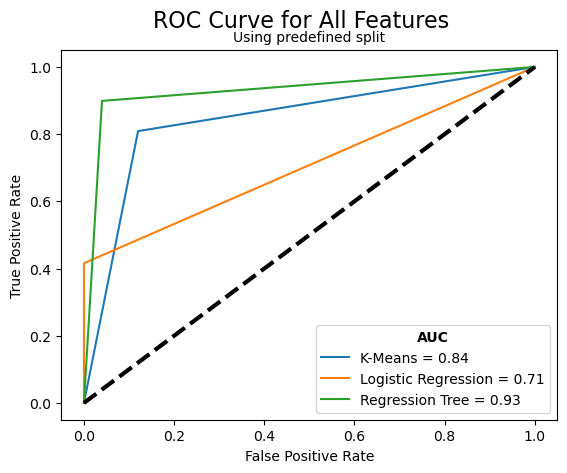

Accuracy (K-Means): 0.868421052631579
Confusion Matrix (K-Means):
[[10 15]
 [ 0 89]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        25
           1       0.86      1.00      0.92        89

    accuracy                           0.87       114
   macro avg       0.93      0.70      0.75       114
weighted avg       0.89      0.87      0.85       114

Accuracy (Logistic Regression): 0.8771929824561403
Confusion Matrix (Logistic Regression):
[[23  2]
 [12 77]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.66      0.92      0.77        25
           1       0.97      0.87      0.92        89

    accuracy                           0.88       114
   macro avg       0.82      0.89      0.84       114
weighted avg       0.91      0.88      0.88       114

Accuracy (Regression Tree): 0.5877192982456141
Confusion Matrix (Regressi

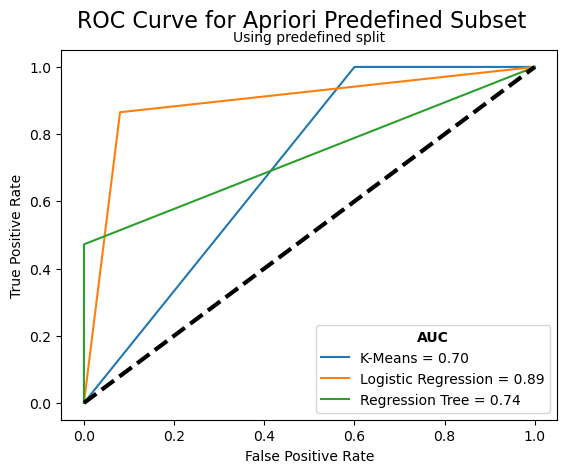

Accuracy (K-Means): 0.868421052631579
Confusion Matrix (K-Means):
[[10 15]
 [ 0 89]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        25
           1       0.86      1.00      0.92        89

    accuracy                           0.87       114
   macro avg       0.93      0.70      0.75       114
weighted avg       0.89      0.87      0.85       114

Accuracy (Logistic Regression): 0.868421052631579
Confusion Matrix (Logistic Regression):
[[25  0]
 [15 74]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        25
           1       1.00      0.83      0.91        89

    accuracy                           0.87       114
   macro avg       0.81      0.92      0.84       114
weighted avg       0.92      0.87      0.88       114

Accuracy (Regression Tree): 0.9210526315789473
Confusion Matrix (Regressio

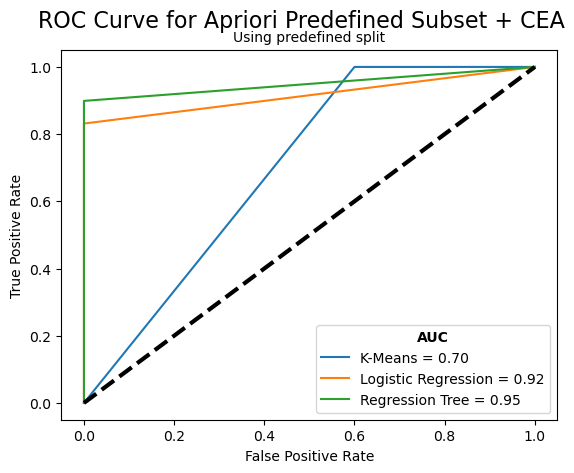

Accuracy (K-Means): 0.7719298245614035
Confusion Matrix (K-Means):
[[ 8 17]
 [ 9 80]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.47      0.32      0.38        25
           1       0.82      0.90      0.86        89

    accuracy                           0.77       114
   macro avg       0.65      0.61      0.62       114
weighted avg       0.75      0.77      0.76       114

Accuracy (Logistic Regression): 0.9385964912280702
Confusion Matrix (Logistic Regression):
[[24  1]
 [ 6 83]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        25
           1       0.99      0.93      0.96        89

    accuracy                           0.94       114
   macro avg       0.89      0.95      0.92       114
weighted avg       0.95      0.94      0.94       114

Accuracy (Regression Tree): 0.5877192982456141
Confusion Matrix (Regress

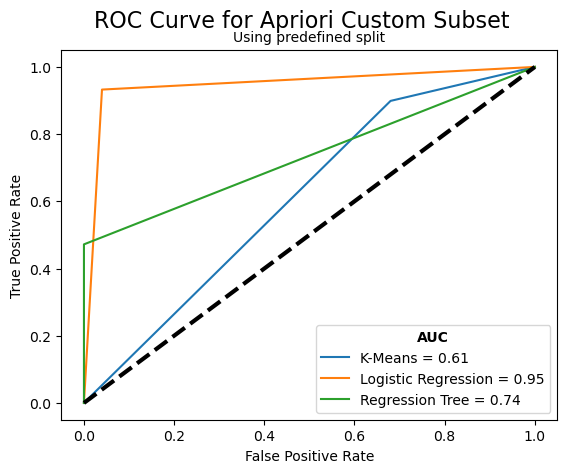

Accuracy (K-Means): 0.7631578947368421
Confusion Matrix (K-Means):
[[ 8 17]
 [10 79]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.44      0.32      0.37        25
           1       0.82      0.89      0.85        89

    accuracy                           0.76       114
   macro avg       0.63      0.60      0.61       114
weighted avg       0.74      0.76      0.75       114

Accuracy (Logistic Regression): 0.9122807017543859
Confusion Matrix (Logistic Regression):
[[24  1]
 [ 9 80]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        25
           1       0.99      0.90      0.94        89

    accuracy                           0.91       114
   macro avg       0.86      0.93      0.88       114
weighted avg       0.93      0.91      0.92       114

Accuracy (Regression Tree): 0.9210526315789473
Confusion Matrix (Regress

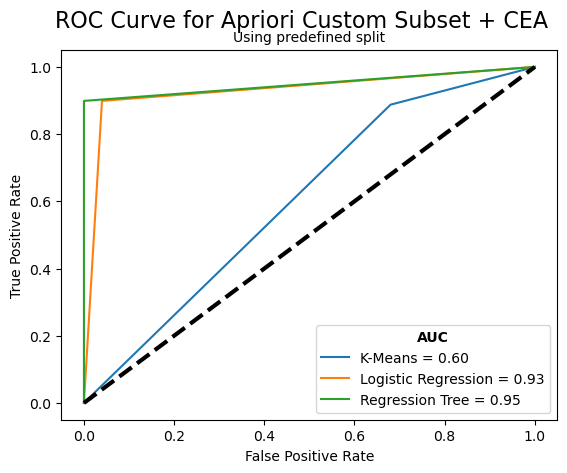

Accuracy (K-Means): 0.8333333333333334
Confusion Matrix (K-Means):
[[14 11]
 [ 8 81]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        25
           1       0.88      0.91      0.90        89

    accuracy                           0.83       114
   macro avg       0.76      0.74      0.75       114
weighted avg       0.83      0.83      0.83       114

Accuracy (Logistic Regression): 0.8421052631578947
Confusion Matrix (Logistic Regression):
[[25  0]
 [18 71]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        25
           1       1.00      0.80      0.89        89

    accuracy                           0.84       114
   macro avg       0.79      0.90      0.81       114
weighted avg       0.91      0.84      0.85       114

Accuracy (Regression Tree): 0.5877192982456141
Confusion Matrix (Regress

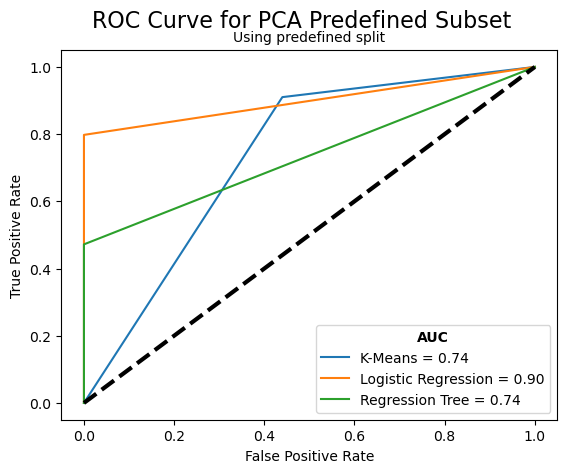

Accuracy (K-Means): 0.8333333333333334
Confusion Matrix (K-Means):
[[14 11]
 [ 8 81]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        25
           1       0.88      0.91      0.90        89

    accuracy                           0.83       114
   macro avg       0.76      0.74      0.75       114
weighted avg       0.83      0.83      0.83       114

Accuracy (Logistic Regression): 0.8157894736842105
Confusion Matrix (Logistic Regression):
[[25  0]
 [21 68]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        25
           1       1.00      0.76      0.87        89

    accuracy                           0.82       114
   macro avg       0.77      0.88      0.79       114
weighted avg       0.90      0.82      0.83       114

Accuracy (Regression Tree): 0.9210526315789473
Confusion Matrix (Regress

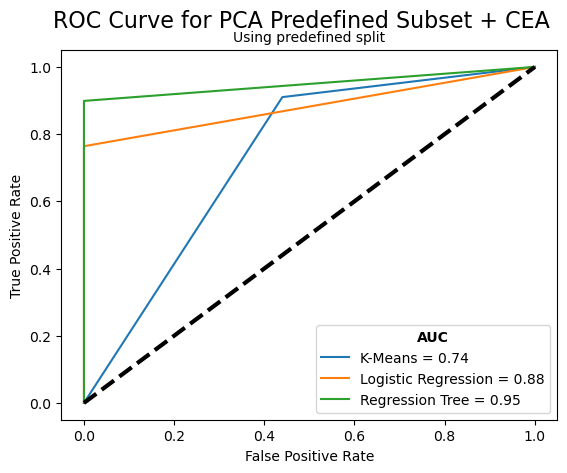

Accuracy (K-Means): 0.8421052631578947
Confusion Matrix (K-Means):
[[10 15]
 [ 3 86]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.77      0.40      0.53        25
           1       0.85      0.97      0.91        89

    accuracy                           0.84       114
   macro avg       0.81      0.68      0.72       114
weighted avg       0.83      0.84      0.82       114

Accuracy (Logistic Regression): 0.8421052631578947
Confusion Matrix (Logistic Regression):
[[24  1]
 [17 72]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.59      0.96      0.73        25
           1       0.99      0.81      0.89        89

    accuracy                           0.84       114
   macro avg       0.79      0.88      0.81       114
weighted avg       0.90      0.84      0.85       114

Accuracy (Regression Tree): 0.5877192982456141
Confusion Matrix (Regress

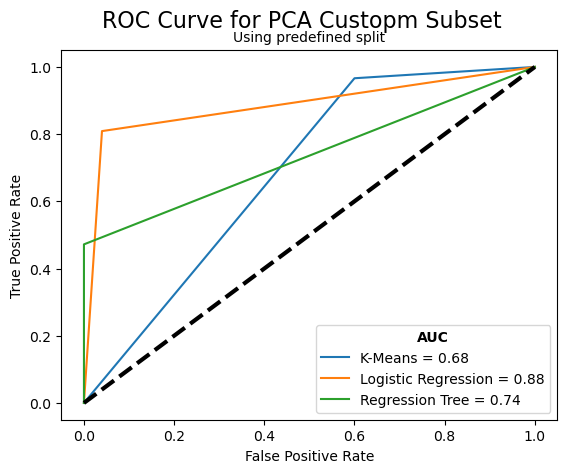

Accuracy (K-Means): 0.8421052631578947
Confusion Matrix (K-Means):
[[10 15]
 [ 3 86]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.77      0.40      0.53        25
           1       0.85      0.97      0.91        89

    accuracy                           0.84       114
   macro avg       0.81      0.68      0.72       114
weighted avg       0.83      0.84      0.82       114

Accuracy (Logistic Regression): 0.8333333333333334
Confusion Matrix (Logistic Regression):
[[25  0]
 [19 70]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        25
           1       1.00      0.79      0.88        89

    accuracy                           0.83       114
   macro avg       0.78      0.89      0.80       114
weighted avg       0.91      0.83      0.85       114

Accuracy (Regression Tree): 0.9210526315789473
Confusion Matrix (Regress

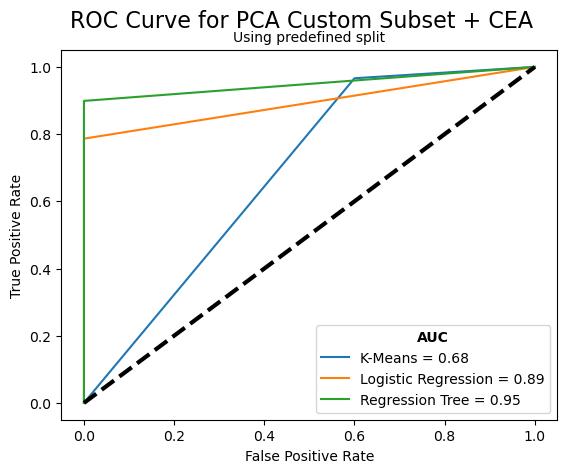

Accuracy (K-Means): 0.8245614035087719
Confusion Matrix (K-Means):
[[22  3]
 [17 72]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.56      0.88      0.69        25
           1       0.96      0.81      0.88        89

    accuracy                           0.82       114
   macro avg       0.76      0.84      0.78       114
weighted avg       0.87      0.82      0.84       114

Accuracy (Logistic Regression): 0.8508771929824561
Confusion Matrix (Logistic Regression):
[[25  0]
 [17 72]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        25
           1       1.00      0.81      0.89        89

    accuracy                           0.85       114
   macro avg       0.80      0.90      0.82       114
weighted avg       0.91      0.85      0.86       114

Accuracy (Regression Tree): 0.9210526315789473
Confusion Matrix (Regress

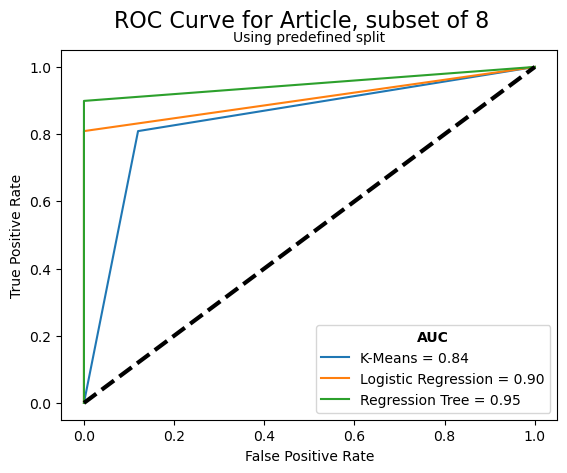

Accuracy (K-Means): 0.9035087719298246
Confusion Matrix (K-Means):
[[16  9]
 [ 2 87]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.91      0.98      0.94        89

    accuracy                           0.90       114
   macro avg       0.90      0.81      0.84       114
weighted avg       0.90      0.90      0.90       114

Accuracy (Logistic Regression): 0.9385964912280702
Confusion Matrix (Logistic Regression):
[[25  0]
 [ 7 82]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        25
           1       1.00      0.92      0.96        89

    accuracy                           0.94       114
   macro avg       0.89      0.96      0.92       114
weighted avg       0.95      0.94      0.94       114

Accuracy (Regression Tree): 0.9210526315789473
Confusion Matrix (Regress

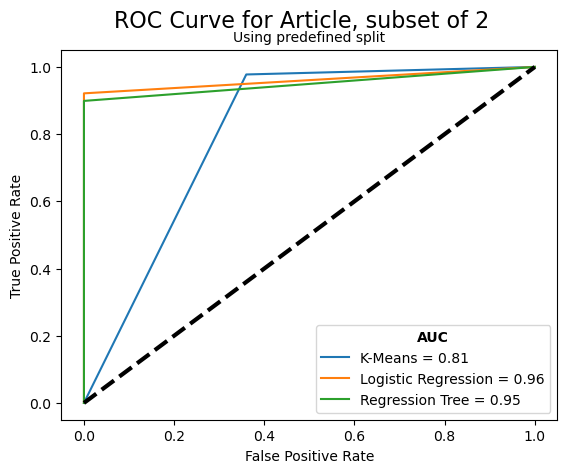

In [69]:
model_eval(split="predefined")

Accuracy (K-Means): 0.7456140350877193
Confusion Matrix (K-Means):
[[43 13]
 [16 42]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        56
           1       0.76      0.72      0.74        58

    accuracy                           0.75       114
   macro avg       0.75      0.75      0.75       114
weighted avg       0.75      0.75      0.75       114

Accuracy (Logistic Regression): 0.868421052631579
Confusion Matrix (Logistic Regression):
[[48  8]
 [ 7 51]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.87      0.86      0.86        56
           1       0.86      0.88      0.87        58

    accuracy                           0.87       114
   macro avg       0.87      0.87      0.87       114
weighted avg       0.87      0.87      0.87       114

Accuracy (Regression Tree): 0.8947368421052632
Confusion Matrix (Regressi

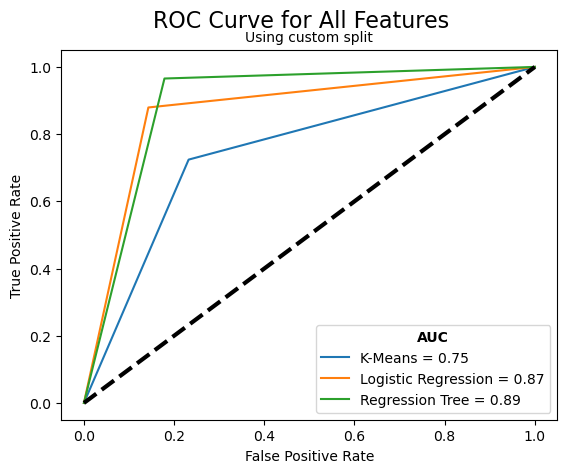

Accuracy (K-Means): 0.6666666666666666
Confusion Matrix (K-Means):
[[18 38]
 [ 0 58]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       1.00      0.32      0.49        56
           1       0.60      1.00      0.75        58

    accuracy                           0.67       114
   macro avg       0.80      0.66      0.62       114
weighted avg       0.80      0.67      0.62       114

Accuracy (Logistic Regression): 0.8421052631578947
Confusion Matrix (Logistic Regression):
[[43 13]
 [ 5 53]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        56
           1       0.80      0.91      0.85        58

    accuracy                           0.84       114
   macro avg       0.85      0.84      0.84       114
weighted avg       0.85      0.84      0.84       114

Accuracy (Regression Tree): 0.8333333333333334
Confusion Matrix (Regress

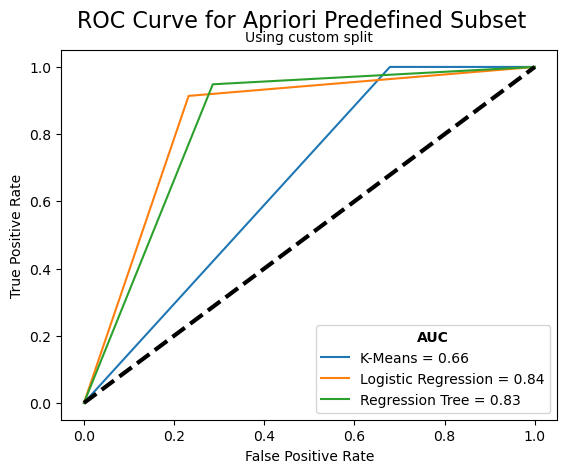

Accuracy (K-Means): 0.6666666666666666
Confusion Matrix (K-Means):
[[18 38]
 [ 0 58]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       1.00      0.32      0.49        56
           1       0.60      1.00      0.75        58

    accuracy                           0.67       114
   macro avg       0.80      0.66      0.62       114
weighted avg       0.80      0.67      0.62       114

Accuracy (Logistic Regression): 0.8859649122807017
Confusion Matrix (Logistic Regression):
[[48  8]
 [ 5 53]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        56
           1       0.87      0.91      0.89        58

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.89      0.89      0.89       114

Accuracy (Regression Tree): 0.8947368421052632
Confusion Matrix (Regress

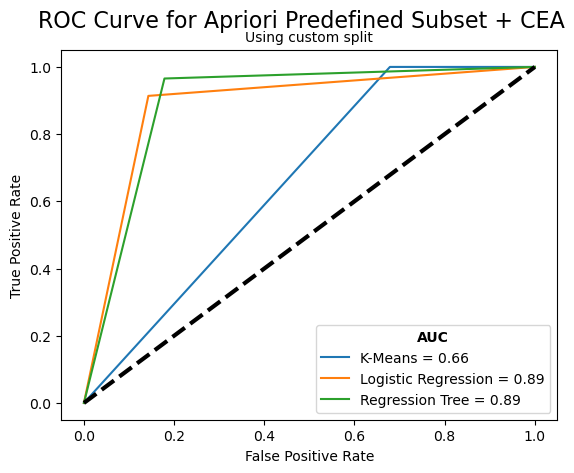

Accuracy (K-Means): 0.6842105263157895
Confusion Matrix (K-Means):
[[31 25]
 [11 47]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.74      0.55      0.63        56
           1       0.65      0.81      0.72        58

    accuracy                           0.68       114
   macro avg       0.70      0.68      0.68       114
weighted avg       0.69      0.68      0.68       114

Accuracy (Logistic Regression): 0.8333333333333334
Confusion Matrix (Logistic Regression):
[[43 13]
 [ 6 52]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        56
           1       0.80      0.90      0.85        58

    accuracy                           0.83       114
   macro avg       0.84      0.83      0.83       114
weighted avg       0.84      0.83      0.83       114

Accuracy (Regression Tree): 0.8245614035087719
Confusion Matrix (Regress

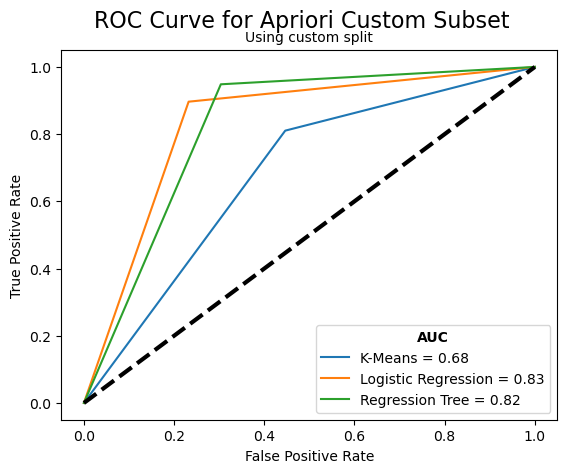

Accuracy (K-Means): 0.6842105263157895
Confusion Matrix (K-Means):
[[31 25]
 [11 47]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.74      0.55      0.63        56
           1       0.65      0.81      0.72        58

    accuracy                           0.68       114
   macro avg       0.70      0.68      0.68       114
weighted avg       0.69      0.68      0.68       114

Accuracy (Logistic Regression): 0.8596491228070176
Confusion Matrix (Logistic Regression):
[[45 11]
 [ 5 53]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        56
           1       0.83      0.91      0.87        58

    accuracy                           0.86       114
   macro avg       0.86      0.86      0.86       114
weighted avg       0.86      0.86      0.86       114

Accuracy (Regression Tree): 0.8947368421052632
Confusion Matrix (Regress

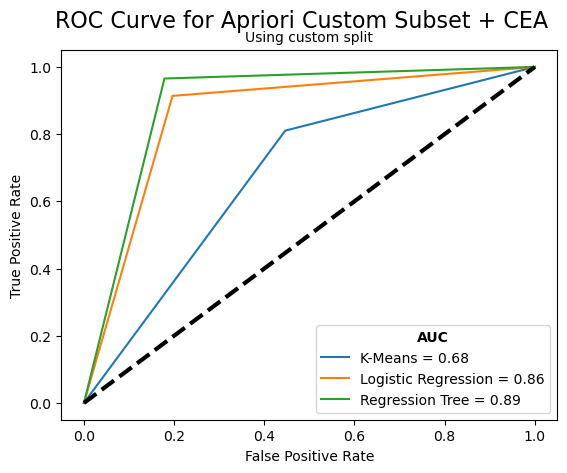

Accuracy (K-Means): 0.7192982456140351
Confusion Matrix (K-Means):
[[27 29]
 [ 3 55]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.90      0.48      0.63        56
           1       0.65      0.95      0.77        58

    accuracy                           0.72       114
   macro avg       0.78      0.72      0.70       114
weighted avg       0.78      0.72      0.70       114

Accuracy (Logistic Regression): 0.8421052631578947
Confusion Matrix (Logistic Regression):
[[43 13]
 [ 5 53]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        56
           1       0.80      0.91      0.85        58

    accuracy                           0.84       114
   macro avg       0.85      0.84      0.84       114
weighted avg       0.85      0.84      0.84       114

Accuracy (Regression Tree): 0.8245614035087719
Confusion Matrix (Regress

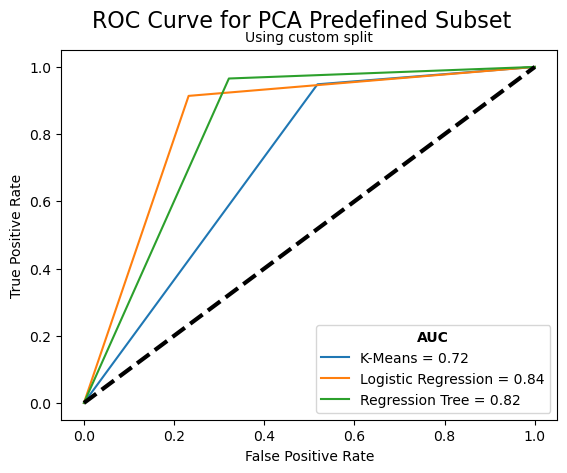

Accuracy (K-Means): 0.7192982456140351
Confusion Matrix (K-Means):
[[27 29]
 [ 3 55]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.90      0.48      0.63        56
           1       0.65      0.95      0.77        58

    accuracy                           0.72       114
   macro avg       0.78      0.72      0.70       114
weighted avg       0.78      0.72      0.70       114

Accuracy (Logistic Regression): 0.8596491228070176
Confusion Matrix (Logistic Regression):
[[45 11]
 [ 5 53]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        56
           1       0.83      0.91      0.87        58

    accuracy                           0.86       114
   macro avg       0.86      0.86      0.86       114
weighted avg       0.86      0.86      0.86       114

Accuracy (Regression Tree): 0.8859649122807017
Confusion Matrix (Regress

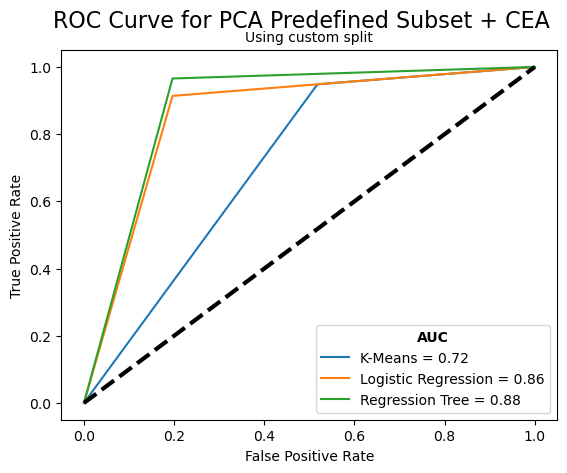

Accuracy (K-Means): 0.7192982456140351
Confusion Matrix (K-Means):
[[29 27]
 [ 5 53]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.85      0.52      0.64        56
           1       0.66      0.91      0.77        58

    accuracy                           0.72       114
   macro avg       0.76      0.72      0.71       114
weighted avg       0.76      0.72      0.71       114

Accuracy (Logistic Regression): 0.8421052631578947
Confusion Matrix (Logistic Regression):
[[44 12]
 [ 6 52]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        56
           1       0.81      0.90      0.85        58

    accuracy                           0.84       114
   macro avg       0.85      0.84      0.84       114
weighted avg       0.85      0.84      0.84       114

Accuracy (Regression Tree): 0.8245614035087719
Confusion Matrix (Regress

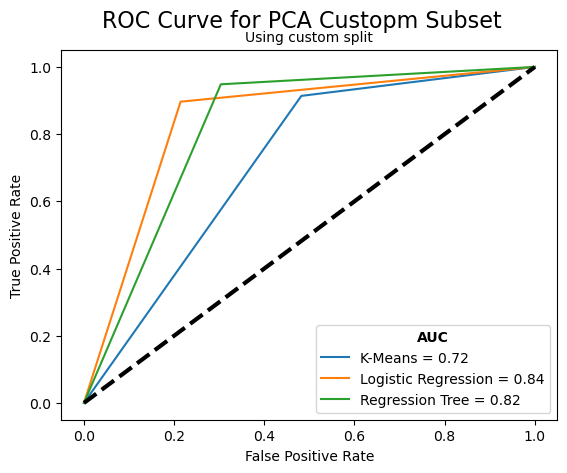

Accuracy (K-Means): 0.7105263157894737
Confusion Matrix (K-Means):
[[28 28]
 [ 5 53]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.85      0.50      0.63        56
           1       0.65      0.91      0.76        58

    accuracy                           0.71       114
   macro avg       0.75      0.71      0.70       114
weighted avg       0.75      0.71      0.70       114

Accuracy (Logistic Regression): 0.8596491228070176
Confusion Matrix (Logistic Regression):
[[46 10]
 [ 6 52]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        56
           1       0.84      0.90      0.87        58

    accuracy                           0.86       114
   macro avg       0.86      0.86      0.86       114
weighted avg       0.86      0.86      0.86       114

Accuracy (Regression Tree): 0.8947368421052632
Confusion Matrix (Regress

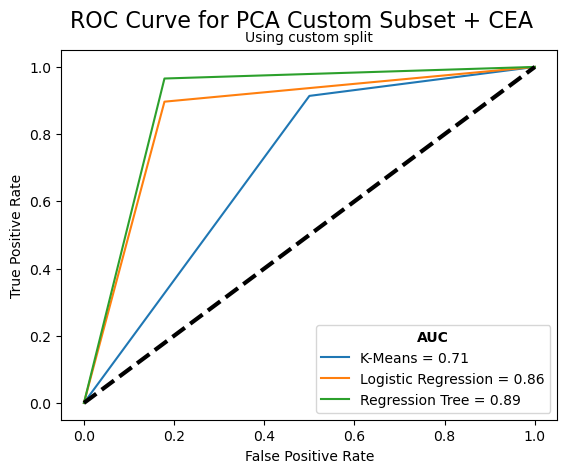

Accuracy (K-Means): 0.7456140350877193
Confusion Matrix (K-Means):
[[43 13]
 [16 42]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        56
           1       0.76      0.72      0.74        58

    accuracy                           0.75       114
   macro avg       0.75      0.75      0.75       114
weighted avg       0.75      0.75      0.75       114

Accuracy (Logistic Regression): 0.868421052631579
Confusion Matrix (Logistic Regression):
[[47  9]
 [ 6 52]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        56
           1       0.85      0.90      0.87        58

    accuracy                           0.87       114
   macro avg       0.87      0.87      0.87       114
weighted avg       0.87      0.87      0.87       114

Accuracy (Regression Tree): 0.8947368421052632
Confusion Matrix (Regressi

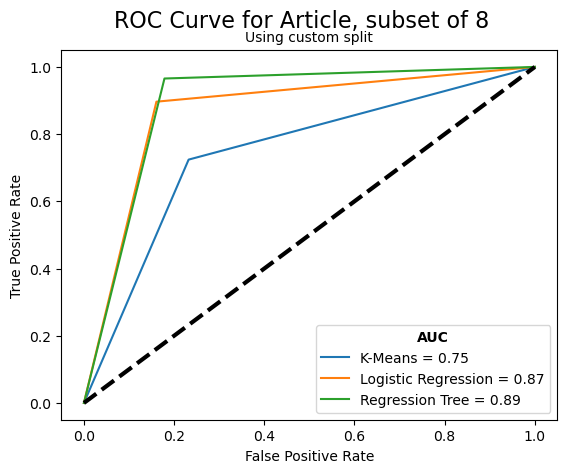

Accuracy (K-Means): 0.7719298245614035
Confusion Matrix (K-Means):
[[30 26]
 [ 0 58]]
Classification Report (K-Means):
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        56
           1       0.69      1.00      0.82        58

    accuracy                           0.77       114
   macro avg       0.85      0.77      0.76       114
weighted avg       0.84      0.77      0.76       114

Accuracy (Logistic Regression): 0.8596491228070176
Confusion Matrix (Logistic Regression):
[[45 11]
 [ 5 53]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        56
           1       0.83      0.91      0.87        58

    accuracy                           0.86       114
   macro avg       0.86      0.86      0.86       114
weighted avg       0.86      0.86      0.86       114

Accuracy (Regression Tree): 0.8947368421052632
Confusion Matrix (Regress

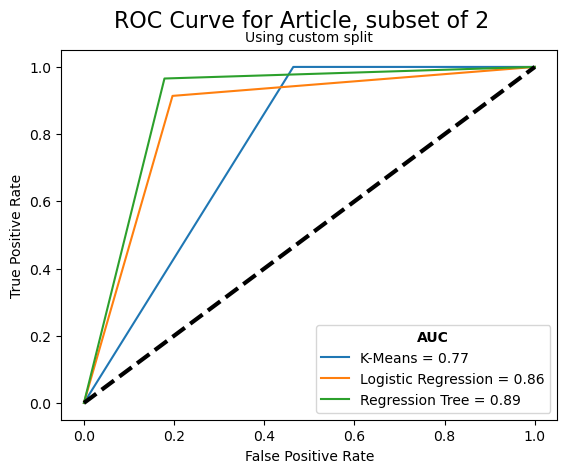

In [70]:
model_eval(split="custom")